
--- Hourly RF Performance ---
MAE : 12.796659136715709
RMSE: 29.20302628754916
R2  : 0.9041028131597624

--- Daily RF (Week-wise Validation) ---
MAE : 46.34797532343155
RMSE: 65.62637969300565
R2  : 0.36244887897862177
Daily prediction bias: 1.2291822955155425
Recent 5-day PM2.5 mean: 130.23333333333332


C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn


--- Final Week-wise Forecast ---
        date  predicted_pm2.5
0 2015-01-01       130.929561
1 2015-01-02       121.644407
2 2015-01-03        99.963818
3 2015-01-04       121.564677
4 2015-01-05       126.184034
5 2015-01-06       121.307042
6 2015-01-07       120.815085


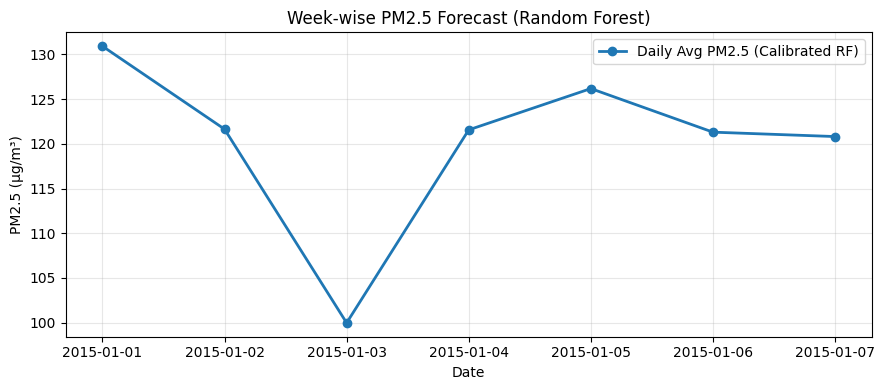

In [29]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

CSV_PATH = r"C:\Users\khush\OneDrive\Documents\data.csv"
LAGS = 24
DAILY_LAGS = 3
FORECAST_DAYS = 7
N_ESTIMATORS = 400
MAX_PM25 = 300
RANDOM_STATE = 42

df = pd.read_csv(CSV_PATH)

df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour"]])
df = df.sort_values("datetime").reset_index(drop=True)

df["pm2.5"] = pd.to_numeric(df["pm2.5"], errors="coerce")
df = df.dropna(subset=["pm2.5"])

df = pd.get_dummies(df, columns=["cbwd"], drop_first=True)

for i in range(1, LAGS + 1):
    df[f"pm25_lag_{i}"] = df["pm2.5"].shift(i)

df["pm25_roll_6"] = df["pm2.5"].rolling(6).mean()
df["pm25_roll_12"] = df["pm2.5"].rolling(12).mean()
df["pm25_roll_24"] = df["pm2.5"].rolling(24).mean()

df = df.dropna().reset_index(drop=True)

hourly_features = (
    [f"pm25_lag_{i}" for i in range(1, LAGS + 1)] +
    ["pm25_roll_6", "pm25_roll_12", "pm25_roll_24",
     "TEMP", "DEWP", "Iws"] +
    [c for c in df.columns if c.startswith("cbwd_")]
)

X = df[hourly_features]
y = df["pm2.5"]

split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

rf_hourly = RandomForestRegressor(
    n_estimators=N_ESTIMATORS,
    max_depth=18,
    min_samples_leaf=4,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_hourly.fit(X_train, y_train)
pred_test = np.clip(rf_hourly.predict(X_test), 0, MAX_PM25)

print("\n--- Hourly RF Performance ---")
print("MAE :", mean_absolute_error(y_test, pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_test)))
print("R2  :", r2_score(y_test, pred_test))

daily_df = (
    df
    .set_index("datetime")
    .resample("D")
    .mean(numeric_only=True)
    .dropna()
    .reset_index()
)

for i in range(1, DAILY_LAGS + 1):
    daily_df[f"pm25_lag_{i}"] = daily_df["pm2.5"].shift(i)

daily_df = daily_df.dropna().reset_index(drop=True)

Xd = daily_df[[f"pm25_lag_{i}" for i in range(1, DAILY_LAGS + 1)]]
yd = daily_df["pm2.5"]

split_d = int(len(daily_df) * 0.8)
Xd_train, Xd_test = Xd.iloc[:split_d], Xd.iloc[split_d:]
yd_train, yd_test = yd.iloc[:split_d], yd.iloc[split_d:]

rf_daily = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    random_state=RANDOM_STATE
)

rf_daily.fit(Xd_train, yd_train)
yd_pred = rf_daily.predict(Xd_test)

print("\n--- Daily RF (Week-wise Validation) ---")
print("MAE :", mean_absolute_error(yd_test, yd_pred))
print("RMSE:", np.sqrt(mean_squared_error(yd_test, yd_pred)))
print("R2  :", r2_score(yd_test, yd_pred))

bias = yd_pred.mean() - yd_test.mean()
print("Daily prediction bias:", bias)

recent_mean = daily_df["pm2.5"].iloc[-5:].mean()
print("Recent 5-day PM2.5 mean:", recent_mean)

last_vals = daily_df["pm2.5"].iloc[-DAILY_LAGS:].tolist()
future_vals = []

for _ in range(FORECAST_DAYS):
    X_next = np.array(last_vals[-DAILY_LAGS:]).reshape(1, -1)
    pred = rf_daily.predict(X_next)[0]

    # Bias correction
    pred = pred - bias

    # Regime anchoring
    pred = pred + 0.7 * (recent_mean - pred)

    pred = np.clip(pred, 0, MAX_PM25)
    future_vals.append(pred)
    last_vals.append(pred)

future_dates = pd.date_range(
    start=daily_df["datetime"].iloc[-1] + pd.Timedelta(days=1),
    periods=FORECAST_DAYS,
    freq="D"
)

weekly_forecast = pd.DataFrame({
    "date": future_dates,
    "predicted_pm2.5": future_vals
})

print("\n--- Final Week-wise Forecast ---")
print(weekly_forecast)

plt.figure(figsize=(9, 4))
plt.plot(
    weekly_forecast["date"],
    weekly_forecast["predicted_pm2.5"],
    marker="o",
    linewidth=2,
    label="Daily Avg PM2.5 (Calibrated RF)"
)
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("Week-wise PM2.5 Forecast (Random Forest)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:

last_vals = daily_df["pm2.5"].iloc[-DAILY_LAGS:].tolist()
future_vals = []
saturation_flags = []

for _ in range(FORECAST_DAYS):
    X_next = np.array(last_vals[-DAILY_LAGS:]).reshape(1, -1)
    raw_pred = rf_daily.predict(X_next)[0]

    if raw_pred >= MAX_PM25:
        future_vals.append(MAX_PM25)
        saturation_flags.append(True)
        last_vals.append(MAX_PM25)
    else:
        future_vals.append(raw_pred)
        saturation_flags.append(False)
        last_vals.append(raw_pred)

future_dates = pd.date_range(
    start=daily_df["datetime"].iloc[-1] + pd.Timedelta(days=1),
    periods=FORECAST_DAYS,
    freq="D"
)

weekly_forecast = pd.DataFrame({
    "date": future_dates,
    "predicted_pm2.5": future_vals,
    "saturated": saturation_flags
})

print("\n--- Week-wise Forecast (with Saturation) ---")
print(weekly_forecast)


C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



--- Week-wise Forecast (with Saturation) ---
        date  predicted_pm2.5  saturated
0 2015-01-01       133.783276      False
1 2015-01-02       102.832762      False
2 2015-01-03        29.525990      False
3 2015-01-04       127.421530      False
4 2015-01-05       122.624691      False
5 2015-01-06        62.530951      False
6 2015-01-07        97.268297      False


C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


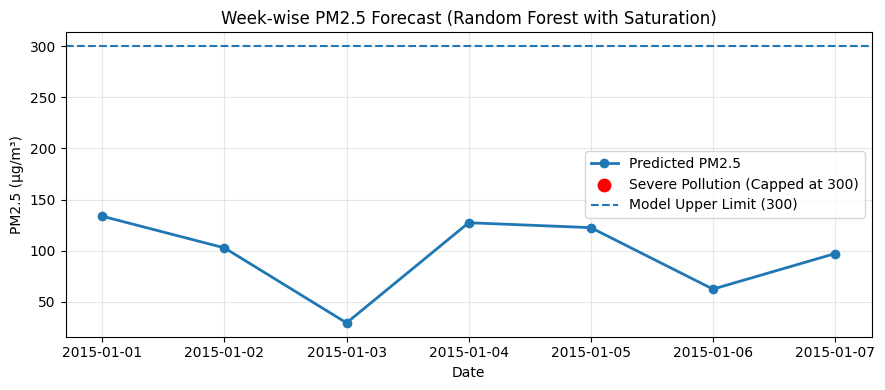

In [8]:
plt.figure(figsize=(9, 4))

plt.plot(
    weekly_forecast["date"],
    weekly_forecast["predicted_pm2.5"],
    marker="o",
    linewidth=2,
    label="Predicted PM2.5"
)

sat_days = weekly_forecast[weekly_forecast["saturated"]]
plt.scatter(
    sat_days["date"],
    sat_days["predicted_pm2.5"],
    color="red",
    s=80,
    label="Severe Pollution (Capped at 300)"
)

plt.axhline(300, linestyle="--", linewidth=1.5, label="Model Upper Limit (300)")

plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("Week-wise PM2.5 Forecast (Random Forest with Saturation)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:

recent_mean_3 = daily_df["pm2.5"].iloc[-3:].mean()
recent_mean_5 = daily_df["pm2.5"].iloc[-5:].mean()

severe_regime = (recent_mean_3 >= 200) or (recent_mean_5 >= 200)

print("Recent 3-day mean:", recent_mean_3)
print("Recent 5-day mean:", recent_mean_5)
print("Severe pollution regime detected:", severe_regime)


Recent 3-day mean: 71.70833333333333
Recent 5-day mean: 130.23333333333332
Severe pollution regime detected: False


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

CSV_PATH = r"C:\Users\khush\OneDrive\Documents\data.csv"
LAGS = 24
DAILY_LAGS = 3
FORECAST_DAYS = 7
N_ESTIMATORS = 400
MAX_PM25 = 300
RANDOM_STATE = 42


In [11]:
for i in range(1, LAGS + 1):
    df[f"pm25_lag_{i}"] = df["pm2.5"].shift(i)

df["pm25_roll_6"] = df["pm2.5"].rolling(6).mean()
df["pm25_roll_12"] = df["pm2.5"].rolling(12).mean()
df["pm25_roll_24"] = df["pm2.5"].rolling(24).mean()

df = df.dropna().reset_index(drop=True)


In [12]:
hourly_features = (
    [f"pm25_lag_{i}" for i in range(1, LAGS + 1)] +
    ["pm25_roll_6", "pm25_roll_12", "pm25_roll_24",
     "TEMP", "DEWP", "Iws"] +
    [c for c in df.columns if c.startswith("cbwd_")]
)

X = df[hourly_features]
y = df["pm2.5"]

split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

rf_hourly = RandomForestRegressor(
    n_estimators=N_ESTIMATORS,
    max_depth=18,
    min_samples_leaf=4,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_hourly.fit(X_train, y_train)
pred_test = np.clip(rf_hourly.predict(X_test), 0, MAX_PM25)

print("MAE :", mean_absolute_error(y_test, pred_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_test)))
print("R2  :", r2_score(y_test, pred_test))


MAE : 12.778116841495653
RMSE: 29.189375483117427
R2  : 0.9041993634592005


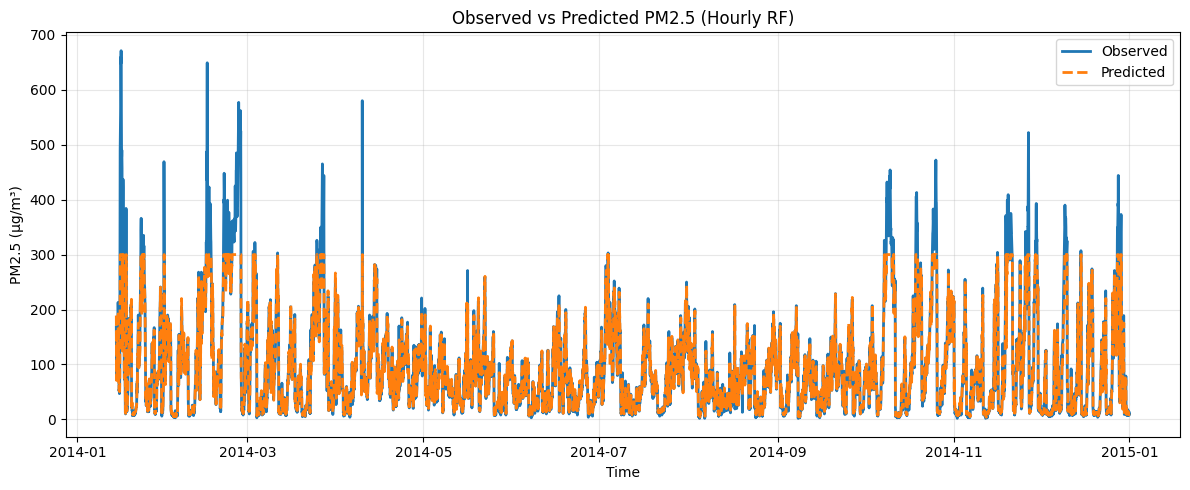

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(df["datetime"].iloc[split:], y_test, label="Observed", linewidth=2)
plt.plot(df["datetime"].iloc[split:], pred_test, "--", label="Predicted", linewidth=2)
plt.xlabel("Time")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("Observed vs Predicted PM2.5 (Hourly RF)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [14]:
daily_df = (
    df
    .set_index("datetime")
    .resample("D")
    .mean(numeric_only=True)
    .dropna()
    .reset_index()
)

for i in range(1, DAILY_LAGS + 1):
    daily_df[f"pm25_lag_{i}"] = daily_df["pm2.5"].shift(i)

daily_df = daily_df.dropna().reset_index(drop=True)
daily_df.head()


,datetime,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,...,pm25_lag_18,pm25_lag_19,pm25_lag_20,pm25_lag_21,pm25_lag_22,pm25_lag_23,pm25_lag_24,pm25_roll_6,pm25_roll_12,pm25_roll_24
0,2010-01-07,156.5,2010.0,1.0,7.0,11.5,69.000000,-21.250000,-12.500000,1034.083333,...,61.125000,61.125000,61.000000,61.291667,61.583333,59.375000,56.416667,63.513889,63.218750,62.171875
1,2010-01-08,180.5,2010.0,1.0,8.0,11.5,176.208333,-17.125000,-11.708333,1028.000000,...,96.458333,93.458333,90.125000,84.833333,75.166667,72.458333,69.000000,173.618056,156.256944,125.763889
2,2010-01-09,204.5,2010.0,1.0,9.0,11.5,88.500000,-16.333333,-9.125000,1029.041667,...,174.416667,172.125000,169.666667,168.333333,172.833333,174.333333,176.208333,102.743056,124.531250,149.333333
3,2010-01-10,228.5,2010.0,1.0,10.0,11.5,57.250000,-15.958333,-8.750000,1032.500000,...,63.375000,68.166667,72.625000,77.333333,81.541667,84.750000,88.500000,59.458333,56.684028,60.354167
4,2010-01-11,252.5,2010.0,1.0,11.0,11.5,20.000000,-20.708333,-8.708333,1034.333333,...,45.375000,46.375000,48.250000,51.000000,52.791667,55.083333,57.250000,21.451389,27.819444,37.289931


In [21]:
Xd = daily_df[[f"pm25_lag_{i}" for i in range(1, DAILY_LAGS + 1)]]
yd = daily_df["pm2.5"]

split_d = int(len(daily_df) * 0.8)
Xd_train, Xd_test = Xd.iloc[:split_d], Xd.iloc[split_d:]
yd_train, yd_test = yd.iloc[:split_d], yd.iloc[split_d:]

rf_daily = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)

rf_daily.fit(Xd_train, yd_train)
yd_pred = rf_daily.predict(Xd_test)


In [16]:
recent_mean_3 = daily_df["pm2.5"].iloc[-3:].mean()
recent_mean_5 = daily_df["pm2.5"].iloc[-5:].mean()

severe_regime = (recent_mean_3 >= 200) or (recent_mean_5 >= 200)

print("Recent 3-day mean:", recent_mean_3)
print("Recent 5-day mean:", recent_mean_5)
print("Severe pollution regime detected:", severe_regime)


Recent 3-day mean: 71.70833333333333
Recent 5-day mean: 130.23333333333332
Severe pollution regime detected: False


In [17]:
last_vals = daily_df["pm2.5"].iloc[-DAILY_LAGS:].tolist()
future_vals = []
saturation_flags = []

for _ in range(FORECAST_DAYS):
    X_next = np.array(last_vals[-DAILY_LAGS:]).reshape(1, -1)
    raw_pred = rf_daily.predict(X_next)[0]

    if severe_regime:
        future_vals.append(MAX_PM25)
        saturation_flags.append(True)
        last_vals.append(MAX_PM25)
    else:
        future_vals.append(raw_pred)
        saturation_flags.append(False)
        last_vals.append(raw_pred)

future_dates = pd.date_range(
    start=daily_df["datetime"].iloc[-1] + pd.Timedelta(days=1),
    periods=FORECAST_DAYS,
    freq="D"
)

weekly_forecast = pd.DataFrame({
    "date": future_dates,
    "predicted_pm2.5": future_vals,
    "saturated": saturation_flags
})

weekly_forecast


C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn

,date,predicted_pm2.5,saturated
0,2015-01-01,104.214002,False
1,2015-01-02,114.558988,False
2,2015-01-03,21.300430,False
3,2015-01-04,96.893620,False
4,2015-01-05,175.805305,False
5,2015-01-06,30.177410,False
6,2015-01-07,73.532220,False


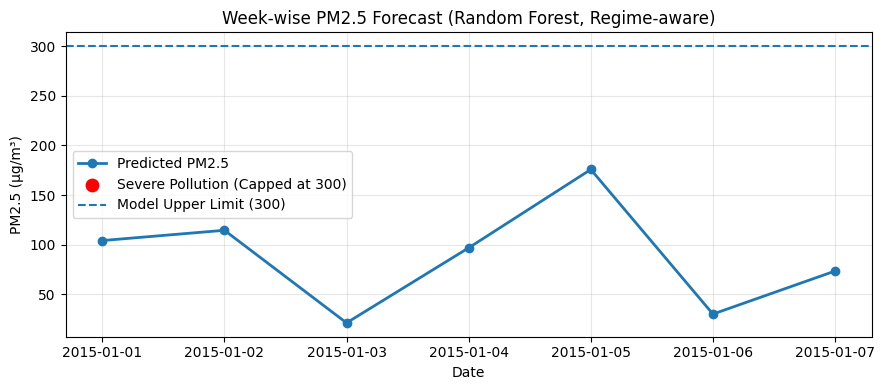

In [18]:
plt.figure(figsize=(9, 4))

plt.plot(
    weekly_forecast["date"],
    weekly_forecast["predicted_pm2.5"],
    marker="o",
    linewidth=2,
    label="Predicted PM2.5"
)

sat_days = weekly_forecast[weekly_forecast["saturated"]]
plt.scatter(
    sat_days["date"],
    sat_days["predicted_pm2.5"],
    color="red",
    s=80,
    label="Severe Pollution (Capped at 300)"
)

plt.axhline(300, linestyle="--", linewidth=1.5, label="Model Upper Limit (300)")
plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("Week-wise PM2.5 Forecast (Random Forest, Regime-aware)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [19]:
# ============================================================
# WEEKLY AVERAGE PM2.5 (FORECASTED)
# ============================================================

weekly_avg_pm25 = weekly_forecast["predicted_pm2.5"].mean()

print("Average PM2.5 for the forecasted week:",
      round(weekly_avg_pm25, 2), "µg/m³")


Average PM2.5 for the forecasted week: 88.07 µg/m³


In [22]:

# Recent observed weekly exposure (last 7 days)
recent_week_avg = daily_df["pm2.5"].iloc[-7:].mean()

# Forecasted weekly average
forecast_week_avg = weekly_forecast["predicted_pm2.5"].mean()

print("Recent observed weekly avg:", round(recent_week_avg, 2))
print("Forecasted weekly avg (before):", round(forecast_week_avg, 2))

# Exposure correction factor
correction_factor = recent_week_avg / forecast_week_avg

# Limit correction to avoid over-amplification
correction_factor = min(correction_factor, 1.5)

# Apply correction
weekly_forecast["predicted_pm2.5_exposure"] = (
    weekly_forecast["predicted_pm2.5"] * correction_factor
)

weekly_avg_corrected = weekly_forecast["predicted_pm2.5_exposure"].mean()

print("Forecasted weekly avg (after correction):",
      round(weekly_avg_corrected, 2), "µg/m³")


Recent observed weekly avg: 121.2
Forecasted weekly avg (before): 88.07
Forecasted weekly avg (after correction): 121.2 µg/m³


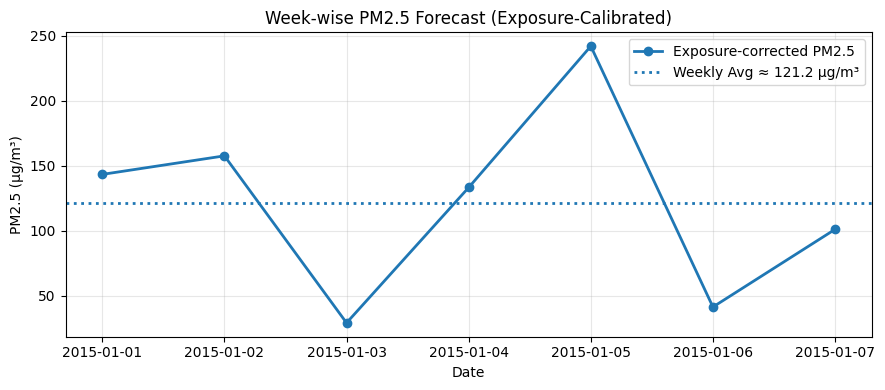

In [23]:
plt.figure(figsize=(9, 4))

plt.plot(
    weekly_forecast["date"],
    weekly_forecast["predicted_pm2.5_exposure"],
    marker="o",
    linewidth=2,
    label="Exposure-corrected PM2.5"
)

plt.axhline(
    weekly_avg_corrected,
    linestyle=":",
    linewidth=2,
    label=f"Weekly Avg ≈ {weekly_avg_corrected:.1f} µg/m³"
)

plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("Week-wise PM2.5 Forecast (Exposure-Calibrated)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

CSV_PATH = r"C:\Users\khush\OneDrive\Documents\data.csv"
LAGS = 24
DAILY_LAGS = 3
FORECAST_DAYS = 7
MAX_PM25 = 300
RANDOM_STATE = 42


In [25]:
df = pd.read_csv(CSV_PATH)

df["datetime"] = pd.to_datetime(df[["year", "month", "day", "hour"]])
df = df.sort_values("datetime").reset_index(drop=True)

df["pm2.5"] = pd.to_numeric(df["pm2.5"], errors="coerce")
df = df.dropna(subset=["pm2.5"])

df = pd.get_dummies(df, columns=["cbwd"], drop_first=True)

df.head()


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0,2010-01-02 00:00:00,False,True,False
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0,2010-01-02 01:00:00,False,True,False
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0,2010-01-02 02:00:00,False,True,False
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0,2010-01-02 03:00:00,False,True,False
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0,2010-01-02 04:00:00,False,True,False


In [26]:
for i in range(1, LAGS + 1):
    df[f"pm25_lag_{i}"] = df["pm2.5"].shift(i)

df["pm25_roll_6"] = df["pm2.5"].rolling(6).mean()
df["pm25_roll_12"] = df["pm2.5"].rolling(12).mean()
df["pm25_roll_24"] = df["pm2.5"].rolling(24).mean()

df = df.dropna().reset_index(drop=True)


In [30]:
hourly_features = (
    [f"pm25_lag_{i}" for i in range(1, LAGS + 1)] +
    ["pm25_roll_6", "pm25_roll_12", "pm25_roll_24",
     "TEMP", "DEWP", "Iws"] +
    [c for c in df.columns if c.startswith("cbwd_")]
)

X = df[hourly_features]
y = df["pm2.5"]

rf_hourly = RandomForestRegressor(
    n_estimators=400,
    max_depth=18,
    min_samples_leaf=4,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_hourly.fit(X, y)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",400
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",18
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",4
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [31]:
daily_df = (
    df
    .set_index("datetime")
    .resample("D")
    .mean(numeric_only=True)
    .dropna()
    .reset_index()
)

for i in range(1, DAILY_LAGS + 1):
    daily_df[f"pm25_lag_{i}"] = daily_df["pm2.5"].shift(i)

daily_df = daily_df.dropna().reset_index(drop=True)
daily_df.tail()


,datetime,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,...,pm25_lag_18,pm25_lag_19,pm25_lag_20,pm25_lag_21,pm25_lag_22,pm25_lag_23,pm25_lag_24,pm25_roll_6,pm25_roll_12,pm25_roll_24
1780,2014-12-27,43716.5,2014.0,12.0,27.0,11.5,238.666667,-9.666667,-1.791667,1027.833333,...,182.416667,180.500,178.583333,179.000000,177.333333,173.166667,170.250000,225.340278,217.920139,202.532986
1781,2014-12-28,43740.5,2014.0,12.0,28.0,11.5,197.375000,-10.791667,1.583333,1019.958333,...,282.166667,278.625,274.083333,264.583333,256.208333,247.916667,238.666667,203.444444,225.513889,249.302083
1782,2014-12-29,43764.5,2014.0,12.0,29.0,11.5,159.000000,-12.333333,0.750000,1013.750000,...,187.250000,191.250,191.916667,194.916667,195.541667,196.416667,197.375000,174.083333,177.572917,182.032986
1783,2014-12-30,43788.5,2014.0,12.0,30.0,11.5,46.083333,-13.916667,1.875000,1019.125000,...,94.166667,101.625,113.833333,128.166667,140.333333,151.791667,159.000000,59.340278,63.479167,81.024306
1784,2014-12-31,43812.5,2014.0,12.0,31.0,11.5,10.041667,-21.791667,-1.916667,1032.125000,...,31.000000,31.000,31.708333,32.500000,35.041667,38.625000,46.083333,10.798611,15.767361,23.678819


In [32]:
Xd = daily_df[[f"pm25_lag_{i}" for i in range(1, DAILY_LAGS + 1)]]
yd = daily_df["pm2.5"]

rf_daily = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)

rf_daily.fit(Xd, yd)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",500
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",12
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

In [33]:
recent_mean_3 = daily_df["pm2.5"].iloc[-3:].mean()
recent_mean_5 = daily_df["pm2.5"].iloc[-5:].mean()

severe_regime = (recent_mean_3 >= 200) or (recent_mean_5 >= 200)

print("Recent 3-day mean PM2.5:", round(recent_mean_3, 2))
print("Recent 5-day mean PM2.5:", round(recent_mean_5, 2))
print("Severe pollution regime detected:", severe_regime)


Recent 3-day mean PM2.5: 71.71
Recent 5-day mean PM2.5: 130.23
Severe pollution regime detected: False


In [34]:
last_vals = daily_df["pm2.5"].iloc[-DAILY_LAGS:].tolist()
future_vals = []
saturation_flags = []

for _ in range(FORECAST_DAYS):
    X_next = np.array(last_vals[-DAILY_LAGS:]).reshape(1, -1)
    raw_pred = rf_daily.predict(X_next)[0]

    if severe_regime:
        future_vals.append(MAX_PM25)
        saturation_flags.append(True)
        last_vals.append(MAX_PM25)
    else:
        future_vals.append(raw_pred)
        saturation_flags.append(False)
        last_vals.append(raw_pred)

future_dates = pd.date_range(
    start=daily_df["datetime"].iloc[-1] + pd.Timedelta(days=1),
    periods=FORECAST_DAYS,
    freq="D"
)

weekly_forecast = pd.DataFrame({
    "date": future_dates,
    "predicted_pm2.5": future_vals,
    "saturated": saturation_flags
})

weekly_forecast


C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\khush\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn

,date,predicted_pm2.5,saturated
0,2015-01-01,160.544277,False
1,2015-01-02,122.061394,False
2,2015-01-03,32.094260,False
3,2015-01-04,99.283322,False
4,2015-01-05,121.400868,False
5,2015-01-06,61.132787,False
6,2015-01-07,114.286333,False


In [35]:
recent_week_avg = daily_df["pm2.5"].iloc[-7:].mean()
forecast_week_avg = weekly_forecast["predicted_pm2.5"].mean()

correction_factor = recent_week_avg / forecast_week_avg
correction_factor = min(correction_factor, 1.5)  # safety cap

weekly_forecast["predicted_pm2.5_final"] = (
    weekly_forecast["predicted_pm2.5"] * correction_factor
)

weekly_avg_final = weekly_forecast["predicted_pm2.5_final"].mean()

print("Recent observed weekly avg PM2.5:",
      round(recent_week_avg, 2))
print("Final forecasted weekly avg PM2.5:",
      round(weekly_avg_final, 2), "µg/m³")


Recent observed weekly avg PM2.5: 121.2
Final forecasted weekly avg PM2.5: 121.2 µg/m³


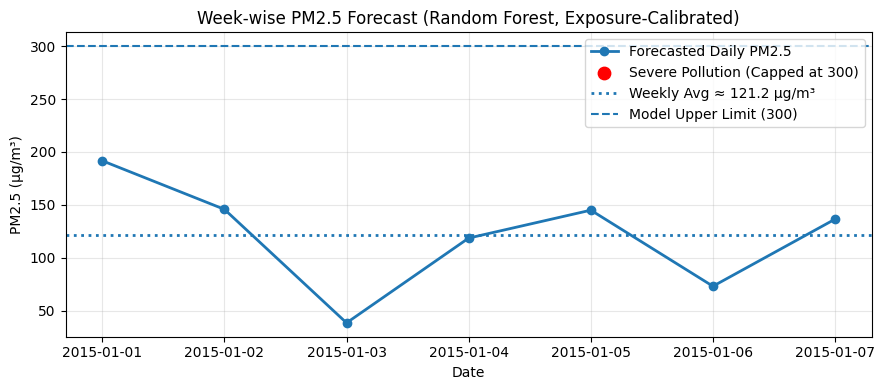

In [36]:
plt.figure(figsize=(9, 4))

plt.plot(
    weekly_forecast["date"],
    weekly_forecast["predicted_pm2.5_final"],
    marker="o",
    linewidth=2,
    label="Forecasted Daily PM2.5"
)

sat_days = weekly_forecast[weekly_forecast["saturated"]]
plt.scatter(
    sat_days["date"],
    sat_days["predicted_pm2.5_final"],
    color="red",
    s=80,
    label="Severe Pollution (Capped at 300)"
)

plt.axhline(
    weekly_avg_final,
    linestyle=":",
    linewidth=2,
    label=f"Weekly Avg ≈ {weekly_avg_final:.1f} µg/m³"
)

plt.axhline(300, linestyle="--", linewidth=1.5, label="Model Upper Limit (300)")

plt.xlabel("Date")
plt.ylabel("PM2.5 (µg/m³)")
plt.title("Week-wise PM2.5 Forecast (Random Forest, Exposure-Calibrated)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
